# Notes

* `d2['file_scores'][k]['paths']` is a matrix of all-pairs segment-to-segment alignments
  * indices are relative to the segment in question
  * same..`['scores']` is the alignment scores: 
  * use `< thresholds['none']` to find the good segment pairs
* generate data from
  * isophonics functions
  * salami functions
  * l2 norm
* samples:
  * features = patches of cqt +- 5 frames on either side
  * positives = drawn from pairs of segments below threshold
  * negatives = "" above the threshold
* model evaluation
  * serra method or laplacian

In [1]:
import numpy as np
import librosa
import cPickle as pickle
import numba
import os
from joblib import Parallel, delayed

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def symstack(X, n_steps=3, delay=1, **kwargs):
    '''Symmetric history stacking.
    
    like librosa.feature.stack_memory, but IN THE FUTURE!!!
    '''
    rpad = n_steps * delay
    Xpad = np.pad(X,
                  [(0, 0), (0, rpad)],
                  **kwargs)
    
    Xstack = librosa.feature.stack_memory(Xpad,
                                          n_steps=2 * n_steps + 1,
                                          delay=delay,
                                          **kwargs)
    
    return Xstack[:, rpad:]

In [4]:
def load_feature_data(file_name, n_steps=5):
    
    fname = '../data/features/{}.pk'.format(file_name)
    
    data = pickle.load(open(fname, 'r'))
    
    return symstack(data['cqgram'].astype(np.float32),
                    n_steps=n_steps,
                    mode='edge'), data['intframes']

In [5]:
@numba.jit
def similarity_paths(X_raw, t_i, t_j, n_samples, max_samples, only_one=True):
    
    X = np.empty((len(t_i), X_raw.shape[0]), dtype=X_raw.dtype)
    
    S = np.zeros((X_raw.shape[1], X_raw.shape[1]))
    
    k = 0
    used_once = np.zeros(X_raw.shape[1], dtype=bool)
    
    for i, j in zip(t_i, t_j):
        if n_samples[i] >= max_samples:
            continue
        
        if only_one and (used_once[i] or used_once[j]):
            continue
            
        S[i, j] = 1
        n_samples[i] += 1
        n_samples[j] += 1
        used_once[i] = True
        used_once[j] = True
        
        #X[k] = np.abs(X_raw[:, i] - X_raw[:, j])
        #k = k + 1
    
    return S

In [6]:
import scipy.spatial

In [7]:
def plot_selfsim(max_samples=4,
                       paths=None,
                       file_name=None,
                       thresholds=None,
                       labels=None,
                       intervals=None,
                       fmeasures=None,
                       scores=None):
    
    # intframes gives the section->cqt frame alignments
    X_raw, intframes = load_feature_data(file_name)
    
    thresh = thresholds['none']
    
    n_segments = len(paths)
    
    n_samples = np.zeros((2, X_raw.shape[1]))
    
    ex_x, ex_y = [], []
    
    S = np.zeros((X_raw.shape[1], X_raw.shape[1]))
    
    for seg_i in range(n_segments):
        off_i = intframes[seg_i, 0]
        
        for seg_j in range(seg_i + 1, len(paths[seg_i])):
            off_j = intframes[seg_j, 0]
            
            
            if not isinstance(paths[seg_i][seg_j], list):
                continue
            
            if not np.isfinite(scores[seg_i, seg_j]):
                continue
            
            if scores[seg_i, seg_j] < thresh:
                y = 1
            else:
                y = -1
            
            
            # Pull out features from the path
            t_i, t_j = paths[seg_i][seg_j]
            t_i = t_i + off_i
            t_j = t_j + off_j
            S += y * similarity_paths(X_raw, t_i, t_j, n_samples[y], max_samples, only_one=(y>0))
            
    return S + S.T, scipy.spatial.distance.cdist(X_raw.T, X_raw.T, metric='cityblock')

In [8]:
@numba.jit
def get_feature_paths(X_raw, t_i, t_j, n_samples, max_samples, only_one=True):
    
    X = np.empty((len(t_i), X_raw.shape[0]), dtype=X_raw.dtype)
    
    k = 0
    used_once = np.zeros(X_raw.shape[1], dtype=bool)
    
    for i, j in zip(t_i, t_j):
        if n_samples[i] >= max_samples:
            continue
            
        if only_one and (used_once[i] or used_once[j]):
            continue
            
        n_samples[i] += 1
        n_samples[j] += 1
        
        used_once[i] = True
        used_once[j] = True
        
        X[k] = np.abs(X_raw[:, i] - X_raw[:, j])
        k = k + 1
    
    return X[:k]

In [72]:
def make_training_data(max_samples=4,
                       paths=None,
                       file_name=None,
                       thresholds=None,
                       labels=None,
                       intervals=None,
                       fmeasures=None,
                       scores=None):
    
    # intframes gives the section->cqt frame alignments
    X_raw, intframes = load_feature_data(file_name)
    
    thresh = thresholds['none']
    
    n_segments = len(paths)
    
    n_samples = np.zeros((2, X_raw.shape[1]))
    
    ex_x, ex_y = [], []
    
    for seg_i in range(n_segments):
        off_i = intframes[seg_i, 0]
        
        for seg_j in range(seg_i + 1, len(paths[seg_i])):
            off_j = intframes[seg_j, 0]
            
            if not isinstance(paths[seg_i][seg_j], list):
                continue
            if not np.isfinite(scores[seg_i, seg_j]):
                continue
                
            if scores[seg_i, seg_j] < thresh:
                y = 1
            else:
                y = 0
                
            # Pull out features from the path
            t_i, t_j = paths[seg_i][seg_j]
            t_i = t_i + off_i
            t_j = t_j + off_j
            
            X = get_feature_paths(X_raw, t_i, t_j, n_samples[y], max_samples, only_one=y)
            ex_x.append(X)
            ex_y.append(y * np.ones(len(X), dtype=np.int32))
    
    if len(ex_x):
        ex_x = np.concatenate(ex_x)
        ex_y = np.concatenate(ex_y)

    else:
        ex_x = np.empty( (0, X_raw.shape[0]), dtype=X_raw.dtype)
        ex_y = np.empty( (0, 1), dtype=np.int32)
        
    return ex_x, ex_y

In [10]:
import os
def process_file(file_scores, max_samples=8):
    
    if file_scores['paths']:
        X, Y = make_training_data(max_samples=max_samples,
                                  **file_scores)
        outfile = '../data/labeled_features/{}_beats.npz'.format(os.path.basename(file_scores['file_name']))
        np.savez(outfile, X=X, Y=Y)

In [59]:
all_data = pickle.load(open('../data/scores_datasetESALAMI_levelEfunction_distEL2.pk'))
#all_data = pickle.load(open('../data/scores_datasetEIsophonics_levelEfunction_distEL2.pk'))

In [60]:
[(x, y['file_name']) for (x,y) in enumerate(all_data['file_scores'])]

[(0, 'SALAMI_396.mp3'),
 (1, 'SALAMI_822.mp3'),
 (2, 'SALAMI_748.mp3'),
 (3, 'SALAMI_564.mp3'),
 (4, 'SALAMI_584.mp3'),
 (5, 'SALAMI_550.mp3'),
 (6, 'SALAMI_1028.mp3'),
 (7, 'SALAMI_1300.mp3'),
 (8, 'SALAMI_248.mp3'),
 (9, 'SALAMI_960.mp3'),
 (10, 'SALAMI_1562.mp3'),
 (11, 'SALAMI_486.mp3'),
 (12, 'SALAMI_1180.mp3'),
 (13, 'SALAMI_990.mp3'),
 (14, 'SALAMI_1462.mp3'),
 (15, 'SALAMI_304.mp3'),
 (16, 'SALAMI_40.mp3'),
 (17, 'SALAMI_356.mp3'),
 (18, 'SALAMI_540.mp3'),
 (19, 'SALAMI_634.mp3'),
 (20, 'SALAMI_970.mp3'),
 (21, 'SALAMI_362.mp3'),
 (22, 'SALAMI_1394.mp3'),
 (23, 'SALAMI_772.mp3'),
 (24, 'SALAMI_842.mp3'),
 (25, 'SALAMI_866.mp3'),
 (26, 'SALAMI_12.mp3'),
 (27, 'SALAMI_1390.mp3'),
 (28, 'SALAMI_892.mp3'),
 (29, 'SALAMI_1258.mp3'),
 (30, 'SALAMI_1314.mp3'),
 (31, 'SALAMI_1338.mp3'),
 (32, 'SALAMI_986.mp3'),
 (33, 'SALAMI_1216.mp3'),
 (34, 'SALAMI_1012.mp3'),
 (35, 'SALAMI_264.mp3'),
 (36, 'SALAMI_1406.mp3'),
 (37, 'SALAMI_18.mp3'),
 (38, 'SALAMI_1092.mp3'),
 (39, 'SALAMI_1426.mp3')

In [74]:
S_p, S = plot_selfsim(max_samples=1000, **all_data['file_scores'][31])

In [75]:
all_data['file_scores'][31]['thresholds']

{'hmean': 1.4379587582468036,
 'max': 1.4369884211215185,
 'min': 1.4389290953720895,
 'none': 25.247213}

In [76]:
np.set_printoptions(precision=0, linewidth=120)

In [77]:
all_data['file_scores'][31]['scores']

array([[   0.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,    0.,  121.,  121.,  123.,  124.,  124.,  138.,  124.,  127.,  137.,   93.],
       [  nan,  121.,    0.,   28.,   28.,   28.,   32.,   40.,   28.,   31.,   49.,  145.],
       [  nan,  121.,   28.,    0.,   27.,   20.,   30.,   40.,   23.,   30.,   50.,  144.],
       [  nan,  123.,   28.,   27.,    0.,   25.,   24.,   41.,   26.,   23.,   50.,  149.],
       [  nan,  124.,   28.,   20.,   25.,    0.,   27.,   39.,   21.,   27.,   50.,  150.],
       [  nan,  124.,   32.,   30.,   24.,   27.,    0.,   47.,   27.,   25.,   49.,  152.],
       [  nan,  138.,   40.,   40.,   41.,   39.,   47.,    0.,   40.,   44.,   37.,  160.],
       [  nan,  124.,   28.,   23.,   26.,   21.,   27.,   40.,    0.,   26.,   49.,  151.],
       [  nan,  127.,   31.,   30.,   23.,   27.,   25.,   44.,   26.,    0.,   47.,  156.],
       [  nan,  137.,   49.,   50.,   50.,   50.,   49.,   37.,   49.,

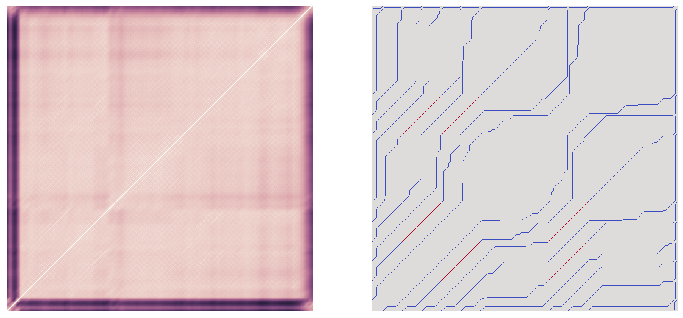

In [78]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
librosa.display.specshow(S, aspect='equal')
plt.subplot(1,2,2)
librosa.display.specshow(S_p, vmin=-1, vmax=1.0, cmap='coolwarm', aspect='equal')

In [73]:
Parallel(n_jobs=4, verbose=20)(delayed(process_file)(data) for data in all_data['file_scores']);

[Parallel(n_jobs=4)]: Done   1 out of 769 | elapsed:    0.6s remaining:  7.8min
[Parallel(n_jobs=4)]: Done  30 out of 769 | elapsed:    1.9s remaining:   46.6s
[Parallel(n_jobs=4)]: Done  69 out of 769 | elapsed:    4.9s remaining:   49.7s
[Parallel(n_jobs=4)]: Done 108 out of 769 | elapsed:    8.9s remaining:   54.5s
[Parallel(n_jobs=4)]: Done 147 out of 769 | elapsed:   13.0s remaining:   54.9s
[Parallel(n_jobs=4)]: Done 186 out of 769 | elapsed:   16.8s remaining:   52.7s
[Parallel(n_jobs=4)]: Done 225 out of 769 | elapsed:   19.6s remaining:   47.4s
[Parallel(n_jobs=4)]: Done 264 out of 769 | elapsed:   24.1s remaining:   46.1s
[Parallel(n_jobs=4)]: Done 303 out of 769 | elapsed:   28.0s remaining:   43.0s
[Parallel(n_jobs=4)]: Done 342 out of 769 | elapsed:   31.3s remaining:   39.1s
[Parallel(n_jobs=4)]: Done 381 out of 769 | elapsed:   37.0s remaining:   37.6s
[Parallel(n_jobs=4)]: Done 420 out of 769 | elapsed:   41.5s remaining:   34.5s
[Parallel(n_jobs=4)]: Done 459 out of 76